# Urban Growth Boundary (UGB)

In [1]:
#import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as stats
from scipy.stats import linregress
import gmaps
import json

#import API keys: 
from config import api_key


In [2]:
# Input cleaned housing data as data frame
housing = pd.read_csv("../Data/HousingTypes_Cleaned.csv")

### Question 1 - Part A: Do cities with a UGB have more multi-unit structures than non-UGB cities?

In [3]:
# Grouping by UGB identifier
units = housing.groupby(["UGB"]).sum()
# Calculating percentages
units = units.div(units["Total Response"], axis=0) * 100

units

,1 unit,2 units,3 or 4 units,5 to 9 units,10 to 19 units,20 to 49 units,50 or more units,Other,Total Response,Median Housing Costs,MOE Housing Costs
UGB,,,,,,,,,,,
No,50.001722,5.864682,6.872485,7.452108,7.377871,7.437085,13.699026,1.295020,100.0,0.428920,0.010382
Yes,52.765238,3.197666,4.092195,5.714007,6.406672,7.950705,18.689253,1.184263,100.0,0.646807,0.014936


In [4]:
# Creating a summary graph of responses 
# Reorganizing data frame for graphing
# Dropping extra columns
units_graph = units.drop(columns=["Total Response", "Median Housing Costs", "MOE Housing Costs"])
# Tranpose data frame
graph_units = units_graph.transpose()
# Reset index
graph_structure = graph_units.reset_index()
graph_structure

UGB,index,No,Yes
0,1 unit,50.001722,52.765238
1,2 units,5.864682,3.197666
2,3 or 4 units,6.872485,4.092195
3,5 to 9 units,7.452108,5.714007
4,10 to 19 units,7.377871,6.406672
5,20 to 49 units,7.437085,7.950705
6,50 or more units,13.699026,18.689253
7,Other,1.295020,1.184263


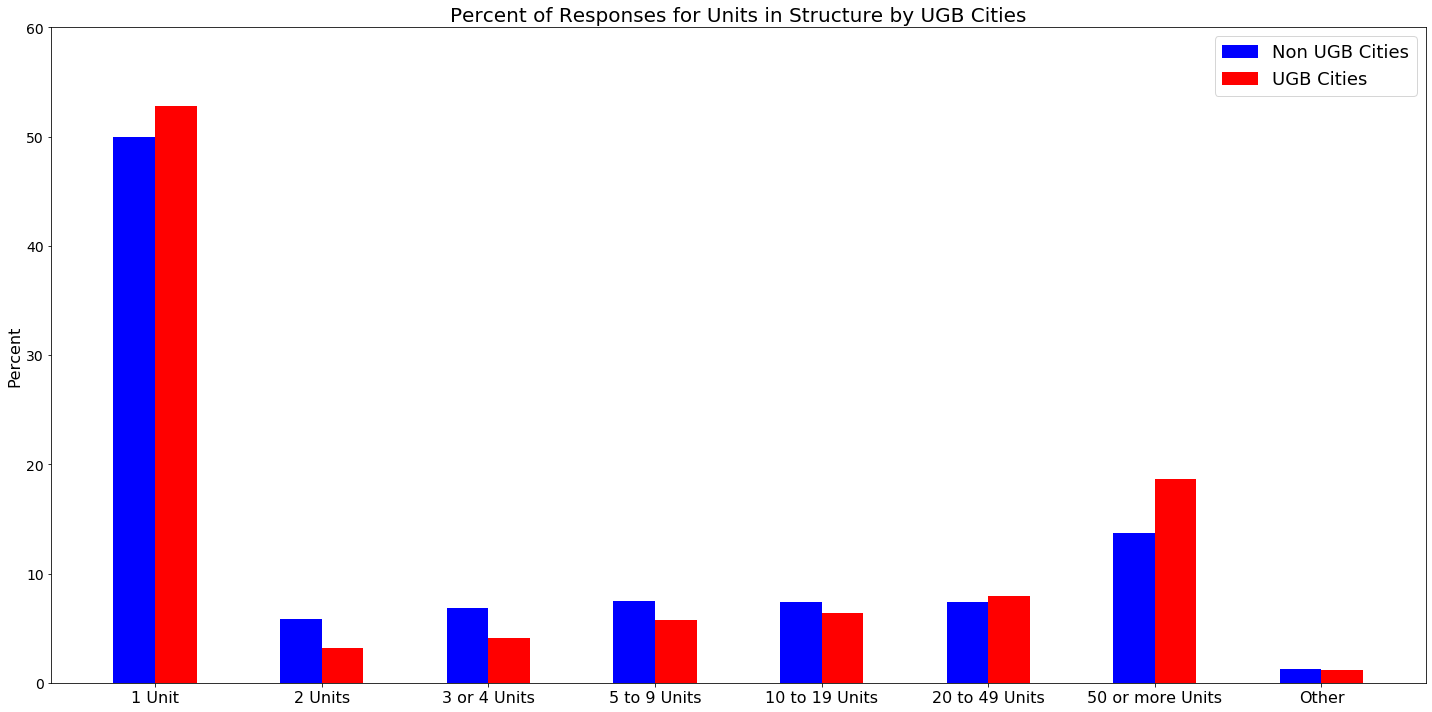

In [5]:
# Bar graph for all response options
# Setting the positions and width for the bars
pos = list(range(len(graph_structure["No"])))
width= 0.25

# X tick labels
x_labels = ("1 Unit", "2 Units", "3 or 4 Units", "5 to 9 Units", "10 to 19 Units", "20 to 49 Units", "50 or more Units", "Other")

# Plotting the bars
fig, ax = plt.subplots(figsize=(20,10))

# Create bars for Non UGB
plt.bar(pos, graph_structure["No"], width, color="blue", label=graph_structure['index'][0])
# Create bars for UGB
plt.bar([p + width for p in pos], graph_structure["Yes"], width, color="red", label=graph_structure['index'][1])

# Set x axis
ax.set_xticks([p + .5 * width for p in pos])
ax.set_xticklabels(x_labels, fontsize=16)
plt.xlim(min(pos)-width*2, max(pos)+width*3)

# Set y axis and labels
ax.tick_params(axis='y', labelsize=14)
plt.ylim(0,60)
plt.ylabel("Percent", fontsize=16)

# Add title and legend
plt.title("Percent of Responses for Units in Structure by UGB Cities", fontsize=20)
plt.legend(["Non UGB Cities", "UGB Cities"], fontsize=18)

# Save graph
plt.savefig("../Images/UnitsinStructure.png")

# Sizing graph to frame and displaying
plt.tight_layout()
plt.show()

In [6]:
# Multi-unit structures
# New data frame
structure = housing.copy()

# Creating single and multi unit variables
structure["Single Unit"] = structure["1 unit"]
structure["Multi Units"] = structure["2 units"] + structure["3 or 4 units"] + structure["5 to 9 units"]\
+ structure["10 to 19 units"] + structure["20 to 49 units"] + structure["50 or more units"]

# Updating Total Columns
structure["Updated Total"] = structure["Single Unit"] + structure["Multi Units"]

# Cleaned data frame
structure_type = structure[["City", "State", "UGB", "Single Unit", "Multi Units", "Updated Total"]].copy()
structure_type

,City,State,UGB,Single Unit,Multi Units,Updated Total
0,New York City,New York,No,559901,2952825,3512726
1,Los Angeles,California,No,644887,847727,1492614
2,Chicago,Illinois,No,366981,857180,1224161
3,Houston,Texas,No,477657,492265,969922
4,Phoenix,Arizona,No,402642,204592,607234
...,...,...,...,...,...,...
95,Fremont,California,No,57268,24267,81535
96,Boise City,Idaho,No,72657,25744,98401
97,Richmond,Virginia,No,55950,44627,100577
98,Baton Rouge,Louisiana,No,64742,39991,104733


In [7]:
# Grouping by UGB
type_graph = structure_type.groupby(["UGB"]).sum()

# Calucaling percents
type_graph = type_graph.div(type_graph["Updated Total"], axis=0) * 100

# Reset index
type_graph = type_graph.reset_index()
type_graph

,UGB,Single Unit,Multi Units,Updated Total
0,No,50.657750,49.342250,100.0
1,Yes,53.397606,46.602394,100.0


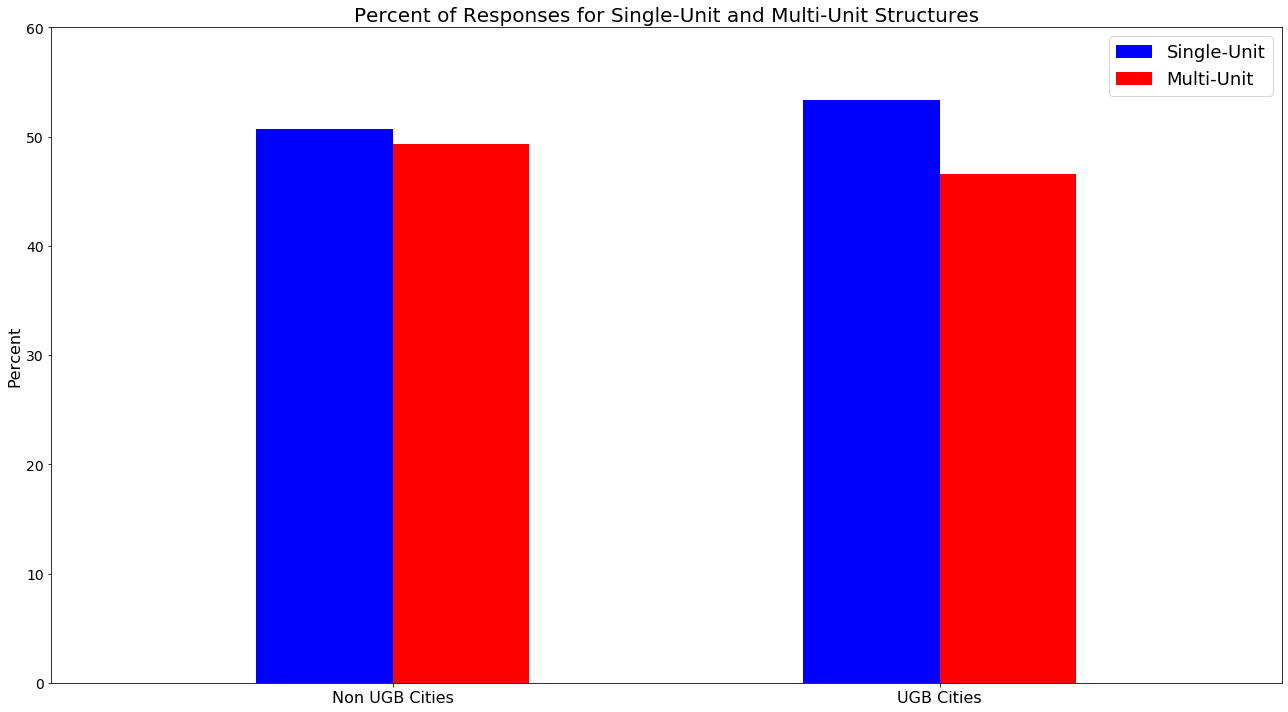

In [8]:
# Bar graph for single units and multi units
# Setting the positions and width for the bars
posi = list(range(len(type_graph["Single Unit"])))
width = 0.25

# X Tick labels
xlabels = ("Non UGB Cities", "UGB Cities")

# Plotting the bars
fig, ax = plt.subplots(figsize=(18,10))

#Create bar set 1
plt.bar(posi, type_graph["Single Unit"], width, color="blue", label=type_graph['UGB'][0])
#Create bar set 2
plt.bar([p + width for p in posi], type_graph["Multi Units"], width, color="red", label=type_graph['UGB'][1])

# Set x axis
ax.set_xticks([p + .5 * width for p in posi])
ax.set_xticklabels(xlabels, fontsize=16)
plt.xlim(min(posi)-width*2, max(posi)+width*3)

# Set y axis and labels
ax.tick_params(axis='y', labelsize=14)
plt.ylim(0,60)
plt.ylabel("Percent", fontsize=16)

# Add title and legend
plt.title("Percent of Responses for Single-Unit and Multi-Unit Structures", fontsize=20)
plt.legend(["Single-Unit", "Multi-Unit"], fontsize=18)

# Save graph
plt.savefig("../Images/SingleUnitvMultiUnit.png")

# Sizing graph to frame and displaying
plt.tight_layout()
plt.show()

In [9]:
# Building data frame to run chi-squared
# Finding Observed Values
ugb_types = structure_type.loc[structure_type["UGB"] == "Yes"]
ugb_singles = ugb_types["Single Unit"].sum()
ugb_multis = ugb_types["Multi Units"].sum()
ugb_total = ugb_types["Updated Total"].sum()

# Finding rate to calculate Expected Values
single_rate = (type_graph.iloc[0, 1]) / 100
multi_rate = (type_graph.iloc[0, 2]) / 100

# Calculate expected values
single_expected = ugb_total * single_rate
multi_expected = ugb_total * multi_rate

# Building data frame
ugb_chi = pd.DataFrame({
    "Type": ["Single Unit", "Multi Unit"],
    "Observed": [ugb_singles, ugb_multis],
    "Expected": [round(single_expected,2), round(multi_expected,2)]
})
ugb_chi

,Type,Observed,Expected
0,Single Unit,1056273,1002075.14
1,Multi Unit,921855,976052.86


In [10]:
# Chi-Squared Goodness of Fit test
# Critical value
critical_value = stats.chi2.ppf(q = 0.95, df = 1)
print(f"The critical value = {round(critical_value,2)}")

# Chi-Squared Test
stats.chisquare(ugb_chi["Observed"], ugb_chi["Expected"])


The critical value = 3.84


Power_divergenceResult(statistic=5940.801499370286, pvalue=0.0)

### Question 1 - Part B: Do cities with a UGB have higher overall cost of housing than non-UGB cities?

In [11]:
# Grouping by UGB identifier
costs = housing[["City", "State", "UGB", "Median Housing Costs", "MOE Housing Costs"]]
costs

,City,State,UGB,Median Housing Costs,MOE Housing Costs
0,New York City,New York,No,1494,9
1,Los Angeles,California,No,1627,11
2,Chicago,Illinois,No,1230,11
3,Houston,Texas,No,1045,14
4,Phoenix,Arizona,No,1097,16
...,...,...,...,...,...
95,Fremont,California,No,2474,80
96,Boise City,Idaho,No,1009,34
97,Richmond,Virginia,No,1066,29
98,Baton Rouge,Louisiana,No,857,28


In [12]:
# Variables for t-test
costs_ugb = costs.loc[costs["UGB"] == "Yes"]
ugb_cost = costs_ugb["Median Housing Costs"]
costs_non = costs.loc[costs["UGB"] == "No"]
non_cost = costs_non["Median Housing Costs"]

# Independent T-test
stats.ttest_ind(ugb_cost, non_cost, equal_var=False)

Ttest_indResult(statistic=1.794108334520519, pvalue=0.10571239387104055)

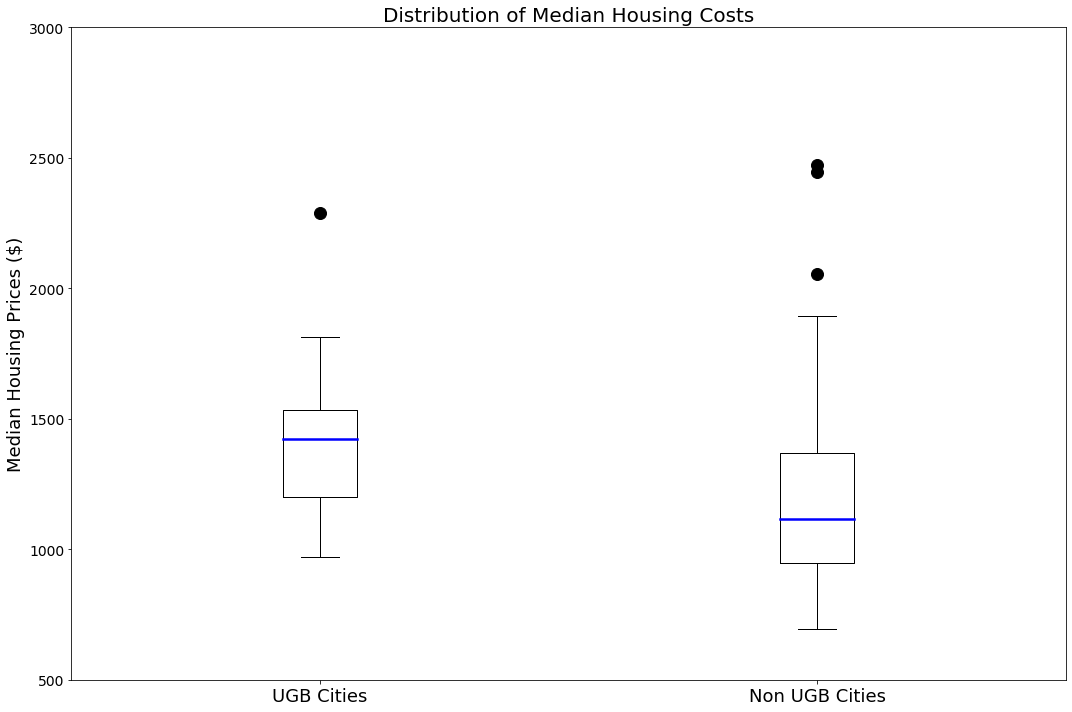

In [13]:
# Creating a Box plot to view data distribution for ugb and non-ugb
# Creating simple data frame to graph from
costs_box = costs[["UGB", "Median Housing Costs"]].copy()
costs_box.set_index("UGB", inplace=True)

# Creating list of values for each box
ugb_box = list(costs_box.loc["Yes", "Median Housing Costs"])
non_ugb = list(costs_box.loc["No", "Median Housing Costs"])

# Creating variable list to pass to boxplot
cities_box = [ugb_box, non_ugb]

# Specifying outlier dots and median line
flierprops = dict(markerfacecolor='black', marker='o', markersize=12)
medianprops = dict(linestyle='-', color="blue", linewidth=2.5)

# Generating figure and drawing boxplot
fig, ax = plt.subplots(figsize=(15,10))
bp = ax.boxplot(cities_box, flierprops=flierprops, medianprops=medianprops)

# Updating y axis
ax.tick_params(axis='y', labelsize=14)
plt.ylim(500,3000)

#Adding title and labels
ax.set_title("Distribution of Median Housing Costs", fontsize=20)
ax.set_ylabel("Median Housing Prices ($)", fontsize=18)
ax.set_xticklabels(["UGB Cities", "Non UGB Cities"], fontsize=18)

# Save graph
plt.savefig("../Images/MedianHousing.png")

# Adjust to frame and display
plt.tight_layout()
plt.show()

# Question 2: Do Residents in UGB Cities use Public Transportation more than those in non-UGB Cities?

In [14]:
transport_data = pd.read_csv("../Data/transportation_data_use_this_one.csv", encoding="ISO-8859-1")
print(transport_data)
transport_data.head()


              City               State                id  UGB    Total  \
0          Boulder            Colorado  1600000US0807850  YES   377551   
1         Honolulu              Hawaii    0500000US15003  YES  1401334   
2        Lexington            Kentucky  1600000US2146027  YES   480471   
3            Miami             Florida  1600000US1245000  YES   634736   
4      Minneapolis           Minnesota  1600000US2743000  YES   686884   
..             ...                 ...               ...  ...      ...   
96          Tucson             Arizona  1600000US0477000   NO   679055   
97           Tulsa            Oklahoma  1600000US4075000   NO   543986   
98      Washington  DistrictofColumbia  1600000US1150000   NO  1043547   
99         Wichita              Kansas  1600000US2079000   NO   538044   
100  Winston-Salem       NorthCarolina  1600000US3775000   NO   312265   

     Commuting Percent  Public Transport percent  \
0       315549  83.58%             62002  16.42%   
1      

,City,State,id,UGB,Total,Commuting,Percent,Public Transport,percent,Estimate!!Total!!No vehicle available,...,"Estimate!!Total!!Taxicab, motorcycle, bicycle, or other means","Estimate!!Total!!Taxicab, motorcycle, bicycle, or other means!!No vehicle available","Estimate!!Total!!Taxicab, motorcycle, bicycle, or other means!!1 vehicle available","Estimate!!Total!!Taxicab, motorcycle, bicycle, or other means!!2 vehicles available","Estimate!!Total!!Taxicab, motorcycle, bicycle, or other means!!3 or more vehicles available",Estimate!!Total!!Worked at home,Estimate!!Total!!Worked at home!!No vehicle available,Estimate!!Total!!Worked at home!!1 vehicle available,Estimate!!Total!!Worked at home!!2 vehicles available,Estimate!!Total!!Worked at home!!3 or more vehicles available
0,Boulder,Colorado,1600000US0807850,YES,377551,315549,83.58%,62002,16.42%,3727,...,2803,4042,1952,21733,606,4930,9387,6810,NaN,NaN
1,Honolulu,Hawaii,0500000US15003,YES,1401334,1245270,88.86%,156064,11.14%,17048,...,17733,1938,6462,3588,5745,16468,547,4444,6001.0,5476.0
2,Lexington,Kentucky,1600000US2146027,YES,480471,456907,95.10%,23564,4.90%,6011,...,3218,580,640,1427,571,7356,0,2017,3979.0,1360.0
3,Miami,Florida,1600000US1245000,YES,634736,561440,88.45%,73296,11.55%,19405,...,6816,2396,2843,1159,418,13811,2059,5747,4055.0,1950.0
4,Minneapolis,Minnesota,1600000US2743000,YES,686884,567964,82.69%,118920,17.31%,21121,...,14444,2691,4832,3851,3070,14320,1082,4906,6822.0,1510.0


In [15]:
summary_table = transport_data.groupby(['UGB'])
print(summary_table)
summary_table.head()

,City,State,id,UGB,Total,Commuting,Percent,Public Transport,percent,Estimate!!Total!!No vehicle available,...,"Estimate!!Total!!Taxicab, motorcycle, bicycle, or other means","Estimate!!Total!!Taxicab, motorcycle, bicycle, or other means!!No vehicle available","Estimate!!Total!!Taxicab, motorcycle, bicycle, or other means!!1 vehicle available","Estimate!!Total!!Taxicab, motorcycle, bicycle, or other means!!2 vehicles available","Estimate!!Total!!Taxicab, motorcycle, bicycle, or other means!!3 or more vehicles available",Estimate!!Total!!Worked at home,Estimate!!Total!!Worked at home!!No vehicle available,Estimate!!Total!!Worked at home!!1 vehicle available,Estimate!!Total!!Worked at home!!2 vehicles available,Estimate!!Total!!Worked at home!!3 or more vehicles available
0,Boulder,Colorado,1600000US0807850,YES,377551,315549,83.58%,62002,16.42%,3727,...,2803,4042,1952,21733,606,4930,9387,6810,NaN,NaN
1,Honolulu,Hawaii,0500000US15003,YES,1401334,1245270,88.86%,156064,11.14%,17048,...,17733,1938,6462,3588,5745,16468,547,4444,6001.0,5476.0
2,Lexington,Kentucky,1600000US2146027,YES,480471,456907,95.10%,23564,4.90%,6011,...,3218,580,640,1427,571,7356,0,2017,3979.0,1360.0
3,Miami,Florida,1600000US1245000,YES,634736,561440,88.45%,73296,11.55%,19405,...,6816,2396,2843,1159,418,13811,2059,5747,4055.0,1950.0
4,Minneapolis,Minnesota,1600000US2743000,YES,686884,567964,82.69%,118920,17.31%,21121,...,14444,2691,4832,3851,3070,14320,1082,4906,6822.0,1510.0
10,Albuquerque,NewMexico,1600000US3502000,NO,756937,727551,96.12%,29386,3.88%,5348,...,4695,505,1461,1954,775,13006,561,3271,5283.0,3891.0
11,Anaheim,California,1600000US0602000,NO,500376,475690,95.07%,24686,4.93%,2858,...,3215,70,951,777,1417,7230,0,1969,2630.0,2631.0
12,Anchorage,Alaska,1600000US0203000,NO,438873,414849,94.53%,24024,5.47%,4662,...,4915,1061,569,1574,1711,5391,0,1253,1576.0,2562.0
13,Arlington,Texas,1600000US4804000,NO,559890,552000,98.59%,7890,1.41%,2542,...,1537,347,396,519,275,7752,52,1926,3576.0,2198.0
14,Atlanta,Georgia,1600000US1304000,NO,697298,610078,87.49%,87220,12.51%,22323,...,8425,1517,3355,1871,1682,17384,620,6462,7436.0,2866.0


In [16]:
commuting_avg = pd.Series(summary_table["Commuting"].mean())
commuting_avg = commuting_avg.round()
commuting_avg


UGB
NO     695363.0
YES    716476.0
Name: Commuting, dtype: float64

In [17]:
public_transport = pd.Series(summary_table['Public Transport'].mean())
public_transport = public_transport.round()
public_transport

UGB
NO      71946.0
YES    108939.0
Name: Public Transport, dtype: float64

In [18]:

ugb_vs_non = pd.DataFrame({'Commuting': commuting_avg, 'Public Transport': public_transport})
print(ugb_vs_non)
ugb_vs_non.head()


     Commuting  Public Transport
UGB                             
NO    695363.0           71946.0
YES   716476.0          108939.0


,Commuting,Public Transport
UGB,,
NO,695363.0,71946.0
YES,716476.0,108939.0


<Figure size 432x288 with 0 Axes>

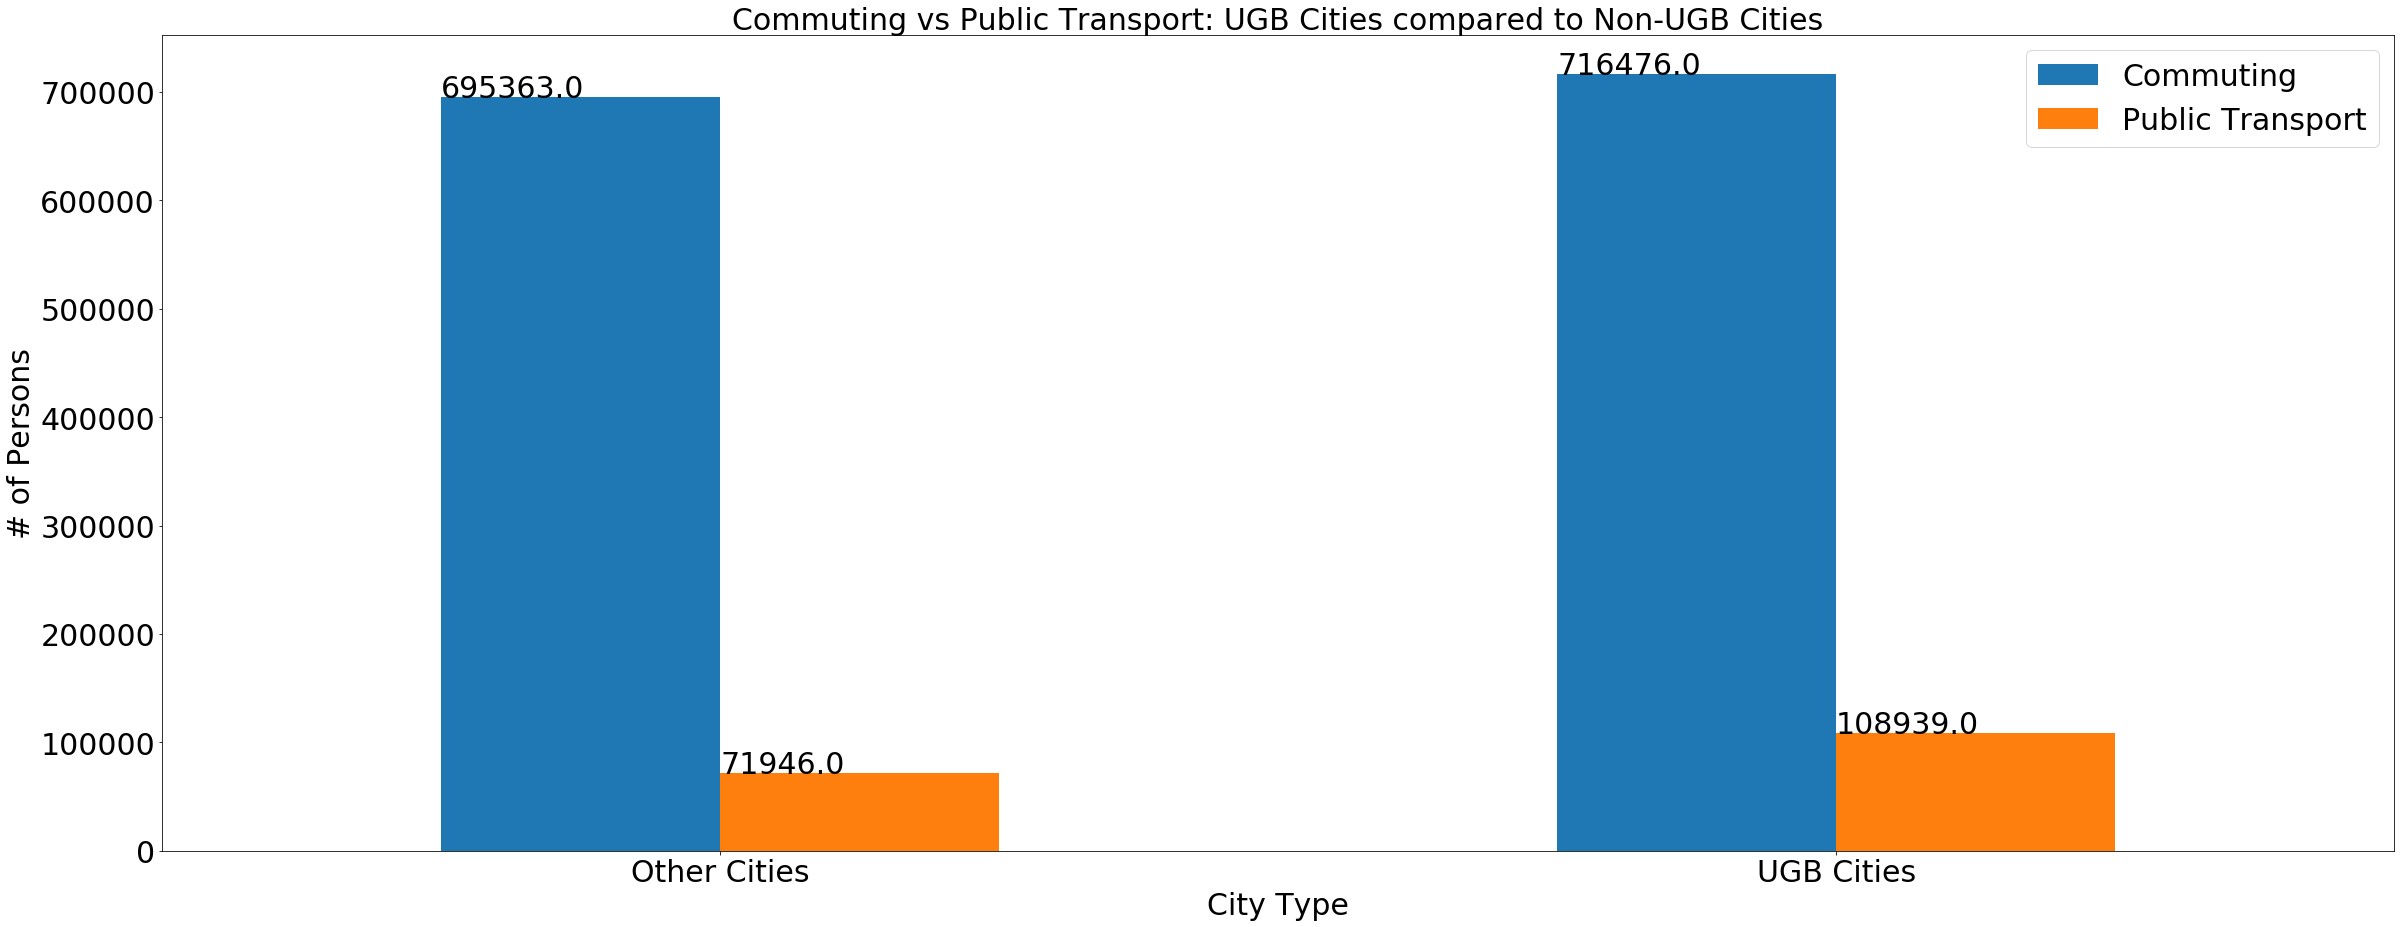

In [56]:
plt.figure()
ax = ugb_vs_non.plot(y=["Commuting", "Public Transport"], kind="bar", figsize=(40,15), fontsize=30)
plt.title("Commuting vs Public Transport: UGB Cities compared to Non-UGB Cities", fontsize=30)
plt.xlabel("City Type", fontsize=30)
plt.ylabel("# of Persons", fontsize=30)
plt.xticks(np.arange(2), ('Other Cities', 'UGB Cities'))
plt.legend(fontsize=30)
plt.xticks(rotation = 0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()), fontsize=30)
plt.savefig("../Images/TransportationGraph.png")                
plt.show()

# Question 3: Do UGB cities have lower population growth than the top 100 US Cities?  Lower than the avg US population growth?

In [20]:
#import csvs
UGB_Popcsv = "../Data/UGB_pop.csv"
UGB_Growcsv = "../Data/UGB_PopGrowth.csv"
top100_Popcsv = "../Data/Top100_CitiesPop.csv"
top100_Growcsv = "../Data/Pop_Growth.csv"

In [21]:
#set up dataframes and check output
#UGB pop and growth
#top 100 pop and growth
UGBpop_df = pd.read_csv(UGB_Popcsv)
UGBgro_df = pd.read_csv(UGB_Growcsv)
Toppop_df = pd.read_csv(top100_Popcsv)
Topgro_df = pd.read_csv(top100_Growcsv)

In [22]:
#merge the top100 Pop and growth, output
top100_df = pd.merge(Toppop_df, Topgro_df, how = "left", on = ["ID", "ID"])
#top100_df.head()

In [23]:
#merge UGB pop and growth, output
UGB_df = pd.merge(UGBpop_df, UGBgro_df, how = "left", on = ["ID", "ID"])
#UGB_df

In [24]:
#reformat the df's, (remove Rank_x, Rank_y, City_y, State_y,
#Estimated Population 2017, Estimated Population 2018)
UGB_df.drop(["Rank_x", "Rank_y", "City_y", "State_y","Estimated Population 2017", "Estimated Population 2018"], axis = 1, inplace = True)
UGB_df.rename(columns = {"Rank_x": "Rank", "City_x": "City", "State_x": "State"}, inplace = True)
UGB_df

,ID,City,State,2010 Census,2011_Estimate,2012_Estimate,2013_Estimate,2014_Estimate,2015_Estimate,2016_Estimate,2017_Estimate,2018_Estimate,Population Difference,Percent Difference
0,668000,San Jose,California,945942,969948,983322,1001253,1014418,1026099,1030359,1032136,1030119,-2017,-0.2
1,5363000,Seattle,Washington,608660,623050,636495,654224,670925,688156,710510,729601,744955,15354,2.1
2,4159000,Portland,Oregon,583776,595410,604285,609970,620647,631539,643136,648630,653115,4485,0.7
3,1245000,Miami,Florida,399457,410673,415270,419829,429365,439404,454293,462030,470914,8884,1.9
4,5182000,Virginia Beach,Virginia,437994,442536,445038,447732,448913,450474,451136,449962,450189,227,0.1
5,2743000,Minneapolis,Minnesota,382578,388022,392775,400108,407122,411150,415239,421072,425403,4331,1.0
6,1571550,Honolulu,Hawaii,337256,343040,346868,349275,349627,351684,351883,349651,347397,-2254,-0.6
7,2146027,Lexington,Kentucky,295803,301736,306075,310010,311955,316002,319738,322193,323780,1587,0.5
8,2758000,St. Paul,Minnesota,285068,288812,291244,295045,297674,300010,303155,305255,307695,2440,0.8
9,807850,Boulder,Colorado,97385,101115,102169,103640,105482,107793,108288,107895,107353,-542,-0.5


In [25]:
#repeat for the top100 cities, rename City_x and State_x
top100_df.drop(["Rank_x", "Rank_y", "City_y", "State_y","Estimated Population 2017", "Estimated Population 2018"], axis = 1, inplace = True)
top100_df.rename(columns = {"Rank_x": "Rank", "City_x": "City", "State_x": "State"}, inplace = True)
top100_df

,ID,City,State,2010 Census,2011_Estimate,2012_Estimate,2013_Estimate,2014_Estimate,2015_Estimate,2016_Estimate,2017_Estimate,2018_Estimate,Population Difference,Percent Difference
0,3651000,New York City,New York,8175133,8272963,8348032,8398739,8437387,8468181,8475976,8438271,8398748,-39523,-0.5
1,644000,Los Angeles,California,3792621,3821136,3852532,3883916,3913260,3943215,3969262,3982002,3990456,8454,0.2
2,1714000,Chicago,Illinois,2695598,2708209,2719735,2726772,2728524,2726215,2718946,2713067,2705994,-7073,-0.3
3,4835000,Houston,Texas,2099451,2124143,2160086,2198280,2240982,2286630,2309752,2317445,2325502,8057,0.3
4,455000,Phoenix,Arizona,1445632,1470052,1499839,1527336,1556552,1584927,1613581,1634984,1660272,25288,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,626000,Fremont,California,214089,217400,221479,224888,228397,231697,233378,234237,237807,3570,1.5
96,1608830,Boise City,Idaho,205671,212620,215681,217436,219471,220938,224728,227621,228790,1169,0.5
97,5167000,Richmond,Virginia,204214,206325,210741,213815,217003,220847,225332,226968,228783,1815,0.8
98,2205000,Baton Rouge,Louisiana,229493,228595,228834,228280,227774,227044,226397,223948,221599,-2349,-1.0


In [26]:
#create statistics
UGB_summ_df = {}
UGB_summ_df = pd.DataFrame()

UGB_summ_df["Avg Population"] = [UGB_df["2018_Estimate"].mean()]
UGB_summ_df["Median Population"] = [UGB_df["2018_Estimate"].median()]
UGB_summ_df["Population Variance"] = [UGB_df["2018_Estimate"].var()]
UGB_summ_df["Population Standard Deviation"] = [UGB_df["2018_Estimate"].std()]
UGB_summ_df["Population SEM"] = [UGB_df["2018_Estimate"].sem()]

UGB_summ_df["Avg Pop Growth"] = [UGB_df["Percent Difference"].mean()]
UGB_summ_df["Median Pop Growth"] = [UGB_df["Percent Difference"].median()]
UGB_summ_df["Pop Growth Variance"] = [UGB_df["Percent Difference"].var()]
UGB_summ_df["Pop Gorwth Standard Deviation"] = [UGB_df["Percent Difference"].std()]
UGB_summ_df["Pop Growth SEM"] = [UGB_df["Percent Difference"].sem()]

UGB_summ_df = pd.DataFrame(UGB_summ_df)
UGB_summ_df

,Avg Population,Median Population,Population Variance,Population Standard Deviation,Population SEM,Avg Pop Growth,Median Pop Growth,Pop Growth Variance,Pop Gorwth Standard Deviation,Pop Growth SEM
0,486092.0,437796.0,6.854721e+10,261815.217268,82793.241266,0.58,0.6,0.855111,0.924722,0.292423


In [27]:
top100_summ_df = {}
top100_summ_df = pd.DataFrame()

top100_summ_df["Avg Population"] = [top100_df["2018_Estimate"].mean()]
top100_summ_df["Median Population"] = [top100_df["2018_Estimate"].median()]
top100_summ_df["Population Variance"] = [top100_df["2018_Estimate"].var()]
top100_summ_df["Population Standard Deviation"] = [top100_df["2018_Estimate"].std()]
top100_summ_df["Population SEM"] = [top100_df["2018_Estimate"].sem()]

top100_summ_df["Avg Pop Growth"] = [top100_df["Percent Difference"].mean()]
top100_summ_df["Median Pop Growth"] = [top100_df["Percent Difference"].median()]
top100_summ_df["Pop Growth Variance"] = [top100_df["Percent Difference"].var()]
top100_summ_df["Pop Gorwth Standard Deviation"] = [top100_df["Percent Difference"].std()]
top100_summ_df["Pop Growth SEM"] = [top100_df["Percent Difference"].sem()]

top100_sum_df = pd.DataFrame(top100_summ_df)
top100_sum_df

,Avg Population,Median Population,Population Variance,Population Standard Deviation,Population SEM,Avg Pop Growth,Median Pop Growth,Pop Growth Variance,Pop Gorwth Standard Deviation,Pop Growth SEM
0,645951.0,390130.5,9.102265e+11,954057.919198,95405.79192,0.712,0.8,0.737632,0.858855,0.085886


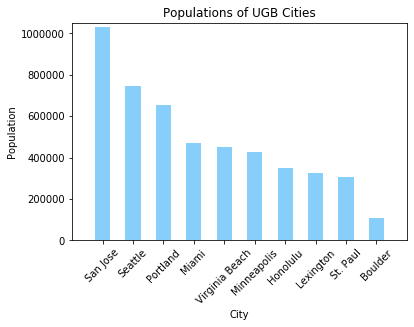

In [28]:
#barchart of UGB cities population
plt.bar(UGB_df["City"], UGB_df["2018_Estimate"], width = 0.5, color = 'lightskyblue')
plt.title("Populations of UGB Cities")
plt.xlabel("City")
plt.ylabel("Population")
plt.xlim(-1,10)
plt.ylim(0,1050000)
plt.xticks(rotation = 45)
plt.savefig("../Images/UGBpop.png")

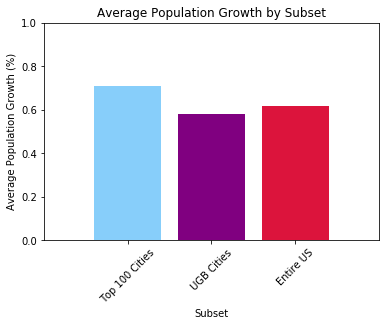

In [29]:
#bar chart of top100, UGB and total US
#compare to total US population growth = .62%, https://www.multpl.com/us-population-growth-rate/table/by-year
plt.bar("Top 100 Cities", top100_summ_df["Avg Pop Growth"], color = 'lightskyblue')
plt.bar("UGB Cities", UGB_summ_df["Avg Pop Growth"], color = 'purple' )
plt.bar("Entire US", [.62], color = 'crimson')
plt.title("Average Population Growth by Subset")
plt.xlabel("Subset")
plt.ylabel("Average Population Growth (%)")
plt.xlim(-1,3)
plt.ylim(0,1)
plt.xticks(rotation = 45)
plt.savefig("../Images/Popgrowth_comp.png")

In [30]:
UGB_growth = ((UGB_summ_df["Avg Pop Growth"]/100) * top100_summ_df["Avg Population"])
top100_growth = ((top100_summ_df["Avg Pop Growth"]/100) * top100_summ_df["Avg Population"])
US_growth = (.0062 * top100_summ_df["Avg Population"])

Pop_growth_df = {}
Pop_growth_df = pd.DataFrame()
Pop_growth_df["UGB Pop Increase"] = UGB_growth
Pop_growth_df["Top 100 City Pop Increase"] = top100_growth
Pop_growth_df["USA Pop Increase"] = US_growth
Pop_growth_df = pd.DataFrame(Pop_growth_df)
Pop_growth_df

,UGB Pop Increase,Top 100 City Pop Increase,USA Pop Increase
0,3746.5158,4599.17112,4004.8962


In [31]:
UGB_sample = (UGB_df["Percent Difference"])
top100_sample = (top100_df["Percent Difference"])
stats.ttest_ind(UGB_sample, top100_sample, equal_var=False)

Ttest_indResult(statistic=-0.43310724388978855, pvalue=0.6736077607856297)

In [32]:
UGB_pop_t = (UGB_df["2018_Estimate"])
top100_pop_t = (top100_df["2018_Estimate"])
stats.ttest_ind(UGB_pop_t, top100_pop_t, equal_var=False)

Ttest_indResult(statistic=-1.2654985761007547, pvalue=0.2126627571576695)

In [33]:
#creat heatmap of UGB cities population growth and decline
target_cities = ["San Jose, California", "Seattle, Washington", "Portland, Oregon", "Miami, Florida", "Virginia Beach, Virginia",
                "Minneapolis, Minnesota", "Honolulu, Hawaii", "Lexington, Kentucky", "St. Paul, Minnesota", "Boulder, Colorado"]

for city in target_cities:
    params = {"address": city, "key": api_key}
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    response = requests.get(base_url, params = params)

    cities_geo = response.json()

    lat = cities_geo["results"][0]["geometry"]["location"]["lat"]
    lng = cities_geo["results"][0]["geometry"]["location"]["lng"]

    print(f"{city}: {lat}, {lng}")

San Jose, California: 37.3382082, -121.8863286
Seattle, Washington: 47.6062095, -122.3320708
Portland, Oregon: 45.5051064, -122.6750261
Miami, Florida: 25.7616798, -80.1917902
Virginia Beach, Virginia: 36.8529263, -75.97798499999999
Minneapolis, Minnesota: 44.977753, -93.2650108
Honolulu, Hawaii: 21.3069444, -157.8583333
Lexington, Kentucky: 38.0405837, -84.5037164
St. Paul, Minnesota: 44.9537029, -93.0899578
Boulder, Colorado: 40.0149856, -105.2705456


In [34]:
#create data frame of the outputs
cities_df = {}
cities_df = pd.DataFrame()

cities_df["City"] = ["San Jose, California", "Seattle, Washington", "Portland, Oregon", "Miami, Florida", "Virginia Beach, Virginia",
                "Minneapolis, Minnesota", "Honolulu, Hawaii", "Lexington, Kentucky", "St. Paul, Minnesota", "Boulder, Colorado"]
cities_df["Lat"] = [37.3382082, 47.6062095, 45.5051064,
                           25.7616798, 36.8529263, 44.977753,
                           21.3069444, 38.0405837, 44.9537029, 40.0149856]
cities_df["Lng"] = ["-121.8863286", "-122.3320708", "-122.6750261", "-80.1917902", "-75.97798499999999", "-93.2650108",
                    "-157.8583333", "-84.5037164", "-93.0899578", "-105.2705456"]

cities_df["Population Growth"] = UGB_df["Percent Difference"]
cities_df = pd.DataFrame(cities_df)
cities_df

,City,Lat,Lng,Population Growth
0,"San Jose, California",37.338208,-121.8863286,-0.2
1,"Seattle, Washington",47.606209,-122.3320708,2.1
2,"Portland, Oregon",45.505106,-122.6750261,0.7
3,"Miami, Florida",25.761680,-80.1917902,1.9
4,"Virginia Beach, Virginia",36.852926,-75.97798499999999,0.1
5,"Minneapolis, Minnesota",44.977753,-93.2650108,1.0
6,"Honolulu, Hawaii",21.306944,-157.8583333,-0.6
7,"Lexington, Kentucky",38.040584,-84.5037164,0.5
8,"St. Paul, Minnesota",44.953703,-93.0899578,0.8
9,"Boulder, Colorado",40.014986,-105.2705456,-0.5


In [35]:
#create heatmap 
locations = cities_df[["Lat", "Lng"]].astype(float)
growth = cities_df["Population Growth"].astype(float)

fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights = (growth + .6), 
                                 dissipating = False, max_intensity = 2.7,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [36]:
#positive cities; Seattle, Portland, Miami, Virginia Beach, Lexington, Minneapolis, St. Paul 
#negative cities; San Jose, Honolulu, Boulder

# Question 4:  Do cities with a UGB have a higher population density than U.S. cities?


In [37]:
#format top 100 cities dataframe
populationcsv = "../Data/top_100clean.csv"
population = pd.read_csv(populationcsv)
population = population.rename(columns = {"Persons by km2": "Persons per km2", "2010 Census": "Census Population"})
population.set_index('City', inplace=True)
#population

In [38]:
#ugb dataframe
ugb = population.loc[population["UGB "] == "Yes", :]
#ugb

In [39]:
#non-ugb cities dataframe
non_ugb = population.loc[population["UGB "] == "No", :]

In [40]:
#set density variables
non_ugb_density = non_ugb["Persons per km2"]
density = population["Persons per km2"]
ugb_density = ugb["Persons per km2"]

In [41]:
#summary statistics
ugb_density_mean = ugb_density.mean()
density_mean = density.mean()
ugb_density_median = ugb_density.median()
density_median = density.median()
min_dens = density.min()
max_dens = density.max()
min_ugb = ugb_density.min()
max_ugb = ugb_density.max()

In [42]:
#summary statistics dataframe
density_summary = pd.DataFrame({'Mean Density':[density_mean], 'Median Density': [density_median], "Minimun Density": [min_dens],
                                "Maximum Density": [max_dens]})
density_summary


,Mean Density,Median Density,Minimun Density,Maximum Density
0,1915.488,1386.0,66.0,13401.8


In [43]:
#summary stats for UGB cities
ugb_density_summary = pd.DataFrame({'UGB Mean Density':[ugb_density_mean], 'UGB Median Density': [ugb_density_median], 
                                    "UGB Minimun Density": [min_ugb], "UGB Maximum Density": [max_ugb]})
ugb_density_summary

,UGB Mean Density,UGB Median Density,UGB Minimun Density,UGB Maximum Density
0,2664.333333,2277.0,438.0,4969.0


In [44]:
#independent t-test of population density
stats.ttest_ind(non_ugb_density, ugb_density, equal_var=False)

Ttest_indResult(statistic=-1.778129731126479, pvalue=0.10164999608986736)

In [45]:
#comfigure gmaps
gmaps.configure(api_key=api_key)

In [46]:
#change data types to float
locations = population[["Latitude", "Longitude"]].astype(float)
ugb_locations =ugb[["Latitude", "Longitude"]].astype(float)
density= population["Persons per km2"].astype(float)
ugb_density = ugb["Persons per km2"].astype(float)

In [47]:
#heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=density, 
                                 dissipating=False, max_intensity=5000,
                                 point_radius = 1)

fig.add_layer(heat_layer)

In [48]:
#add ugb markers
ugb_layer = gmaps.symbol_layer(
    ugb_locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=4)
    
fig = gmaps.figure()
fig.add_layer(ugb_layer)

In [49]:
#add layers and show figure
fig = gmaps.figure()
fig.add_layer(heat_layer)
fig.add_layer(ugb_layer)

fig

Figure(layout=FigureLayout(height='420px'))

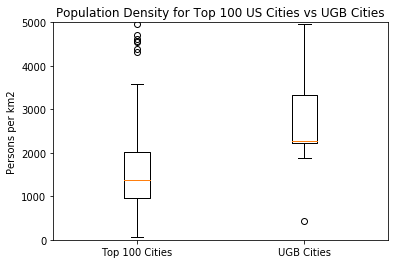

<Figure size 432x288 with 0 Axes>

In [50]:
#create boxplots
data = [density, ugb_density]
fig1, ax1 = plt.subplots()
ax1.set_title('Population Density for Top 100 US Cities vs UGB Cities')
ax1.set_ylabel('Persons per km2')
ax1.boxplot(data)
ax1.set_xticklabels(['Top 100 Cities', 'UGB Cities'])
top = 5000
bottom = 0
ax1.set_ylim(bottom, top)
plt.show()
plt.savefig("../Images/PopD_boxplot.png")
plt.show()

In [51]:
#Top 100 cities quartiles and outliers
quartiles = density.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of population density is: {lowerq}")
print(f"The upper quartile of population density is: {upperq}")
print(f"The interquartile range of population density is: {iqr}")
print(f"The the median of population density is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of population density is: 951.5
The upper quartile of population density is: 2011.0
The interquartile range of population density is: 1059.5
The the median of population density is: 1386.0 
Values below -637.75 could be outliers.
Values above 3600.25 could be outliers.


In [52]:
#UGB cities quartiles and outliers
quartiles = ugb_density.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of UGB population density is: {lowerq}")
print(f"The upper quartile of UGB population density is: {upperq}")
print(f"The interquartile range of UGB population density is: {iqr}")
print(f"The the median of UGB population density is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of UGB population density is: 2234.0
The upper quartile of UGB population density is: 3336.0
The interquartile range of UGB population density is: 1102.0
The the median of UGB population density is: 2277.0 
Values below 581.0 could be outliers.
Values above 4989.0 could be outliers.
